In [164]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score as f1
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score as roc
from sklearn.metrics import accuracy_score as acc
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import recall_score

In [72]:
#  Имеются данные по времени возвращения долга с кредитной карты
# таргет хранится в колонке status 
# Описание таргетов : 0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 
# 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days 
# C: paid off that month X: No loan for the month
# описание данных и сам датасет https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction

In [4]:
# Вначале решим более сложную задачу - многоклассовую классификацию
# После расмотрения на ней различных методов перейдем к задаче кредитного скоринга

In [5]:
application = pd.read_csv("application_record.csv")
credit = pd.read_csv('credit_record.csv')

In [6]:
application.sample(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
98403,5617513,F,Y,N,1,157500.0,Working,Incomplete higher,Married,House / apartment,-11134,-3533,1,1,0,0,Secretaries,3.0
237622,6639547,M,N,N,0,202500.0,Working,Secondary / secondary special,Married,House / apartment,-19851,-1077,1,0,1,0,Drivers,2.0
116585,5522194,M,Y,Y,0,405000.0,Working,Higher education,Married,With parents,-10779,-394,1,1,1,0,Managers,2.0
324096,6288362,F,N,Y,1,202500.0,Commercial associate,Secondary / secondary special,Married,Municipal apartment,-16719,-2316,1,0,0,0,Sales staff,3.0
174470,6047622,M,N,N,0,202500.0,Working,Secondary / secondary special,Married,House / apartment,-15661,-5571,1,0,1,0,Laborers,2.0
290792,6778836,F,N,Y,0,175500.0,Working,Higher education,Married,House / apartment,-14310,-381,1,1,1,0,High skill tech staff,2.0
32259,5095145,F,N,Y,2,157500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-14197,-3350,1,1,1,0,High skill tech staff,3.0
135359,5631897,F,N,Y,0,213750.0,Pensioner,Incomplete higher,Civil marriage,House / apartment,-23273,365243,1,0,0,0,NaN,2.0
259945,6793062,F,Y,N,0,135000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-20535,365243,1,0,1,0,NaN,1.0
190795,6070951,F,N,Y,2,157500.0,Working,Incomplete higher,Separated,House / apartment,-16710,-3914,1,0,0,0,Accountants,3.0


In [7]:
credit.sample(5)

,ID,MONTHS_BALANCE,STATUS
563067,5067366,-31,C
583027,5068535,0,0
602795,5078473,-22,X
772556,5113028,-3,0
706410,5095908,0,0


In [8]:
# Посмотрим на то, какого типа разные фичи

In [9]:
print('Размер датасета',application.shape,'\n\n')
application.info()

Размер датасета (438557, 18) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null

In [10]:
print('Размер датасета',credit.shape,'\n\n')
credit.info()

Размер датасета (1048575, 3) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [11]:
# Взглянем на пропуски в данных

In [12]:
application.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [13]:
# как видим в трети данных пропущено значение профессия
# профессия достаточно важный категориальный признак для задачи кредитного скоринга
# поэтому одно из возможных тактик в данной ситуации заполнить все пропуски
application.fillna(np.nan)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [14]:
credit.isnull().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [15]:
# Дальше удаляю чисто технические колонки телефон/email и тд
application.drop(['FLAG_MOBIL','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL'], axis=1, inplace=True) 

In [16]:
# Строю графики для первичного представления о данных 

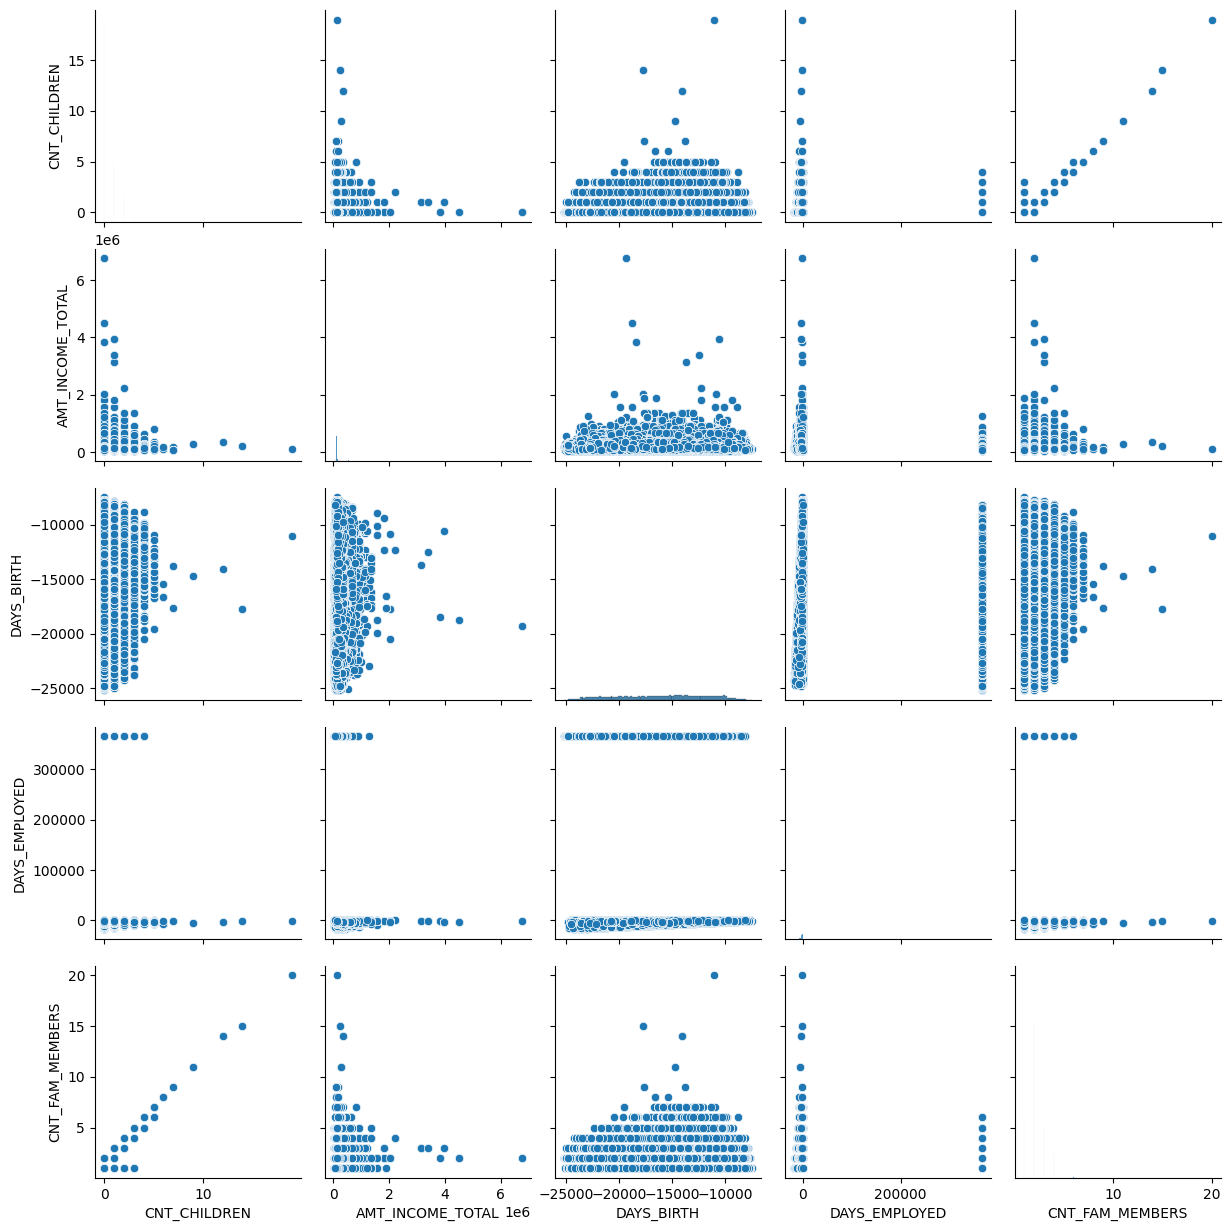

In [14]:
cols = [x for x in application.columns if application[x].dtype != 'object']
cols.remove('ID')
sns.pairplot(application[cols])
#Какие выводы можно первично сделать
# 1) Число детей в семье и размер зависят линейно, что в принципе очевидно
# (Уже на талкивает на мысль использовать PCA, чтобы убрать ненужную ось)
# 2) Второе часть данных имеет большие выбросы

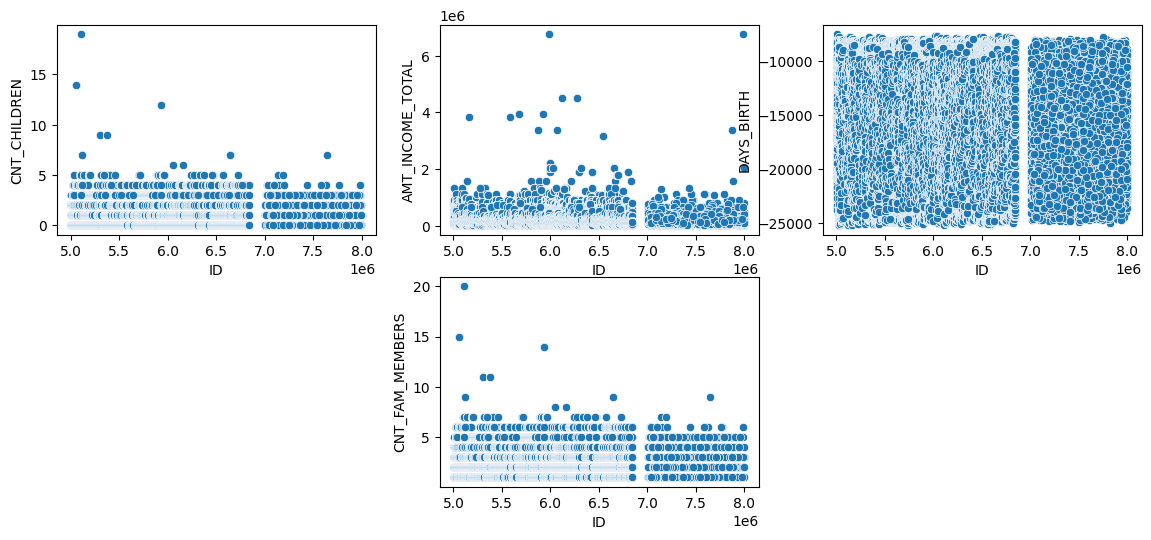

In [15]:
# Построим графики наиболее шумных данных
fig, ax= plt.subplots(nrows= 2, ncols = 3, figsize= (14,6))

sns.scatterplot(x='ID', y='CNT_CHILDREN', data=application, ax=ax[0][0])
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=application, ax=ax[0][1])
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=application, ax=ax[0][2])
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=application, ax=ax[1][1])
fig.delaxes(ax[1][2])
fig.delaxes(ax[1][0])

In [17]:
# Удаляю шумы с помощью межквартильного размаха
q1 = application['CNT_CHILDREN'].quantile(q=0.25)
q2 = application['CNT_CHILDREN'].quantile(q=0.75)
# Так как детей не может отрицательное количество, то оценим только границу сверху 1.5 межквартильными размахами 
# Отмечу, что значение q1 = 0
application = application[application['CNT_CHILDREN']<=q2+(q2-q1)*1.5]
application.shape

(432482, 14)

In [18]:
q1 = application['CNT_CHILDREN'].quantile(q=0.25)
q2 = application['CNT_CHILDREN'].quantile(q=0.75)
# Так как детей не может отрицательное количество, то оценим только границу сверху 1.5 межквартильными размахами 
# Отмечу, что значение q1 = 0
application = application[application['CNT_CHILDREN']<=q2+(q2-q1)*1.5 ]
application.shape

(432482, 14)

In [19]:
# Анологично оцениваю 1.5 межквартильным размахом все остальные данные
q1 = application['CNT_FAM_MEMBERS'].quantile(q=0.25)
q2 = application['CNT_FAM_MEMBERS'].quantile(q=0.75)
application = application[application['CNT_FAM_MEMBERS']<=q2+(q2-q1)*1.5]
application.shape

(432482, 14)

In [20]:
q1 = application['DAYS_BIRTH'].quantile(q=0.25)
q2 = application['DAYS_BIRTH'].quantile(q=0.75)
application = application[(application['DAYS_BIRTH']<=q2+(q2-q1)*1.5) & (application['DAYS_BIRTH']>=q2-(q2-q1)*1.5)]
application.shape

(412321, 14)

In [21]:
# С данными по зарплате надо быть аккуратнее, убрать только единичные случаи
q1 = application['AMT_INCOME_TOTAL'].quantile(q=0.25)
q2 = application['AMT_INCOME_TOTAL'].quantile(q=0.75)
application = application[(application['AMT_INCOME_TOTAL']<=q2+(q2-q1)*2) & (application['AMT_INCOME_TOTAL']>=q2-(q2-q1)*2)]

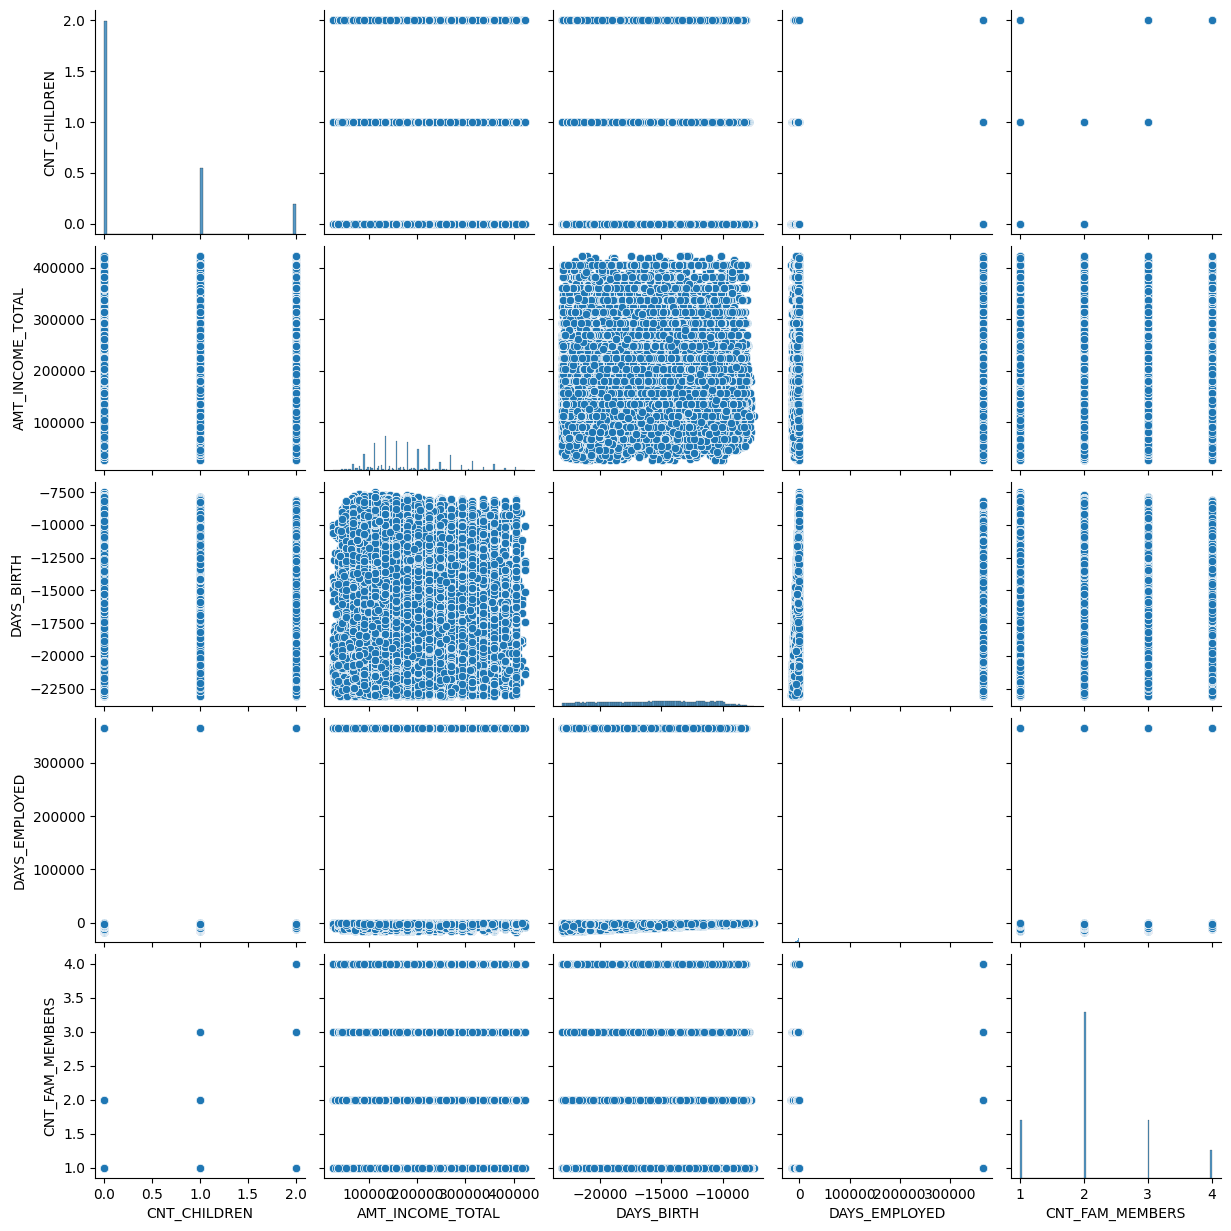

In [21]:
sns.pairplot(application[cols])

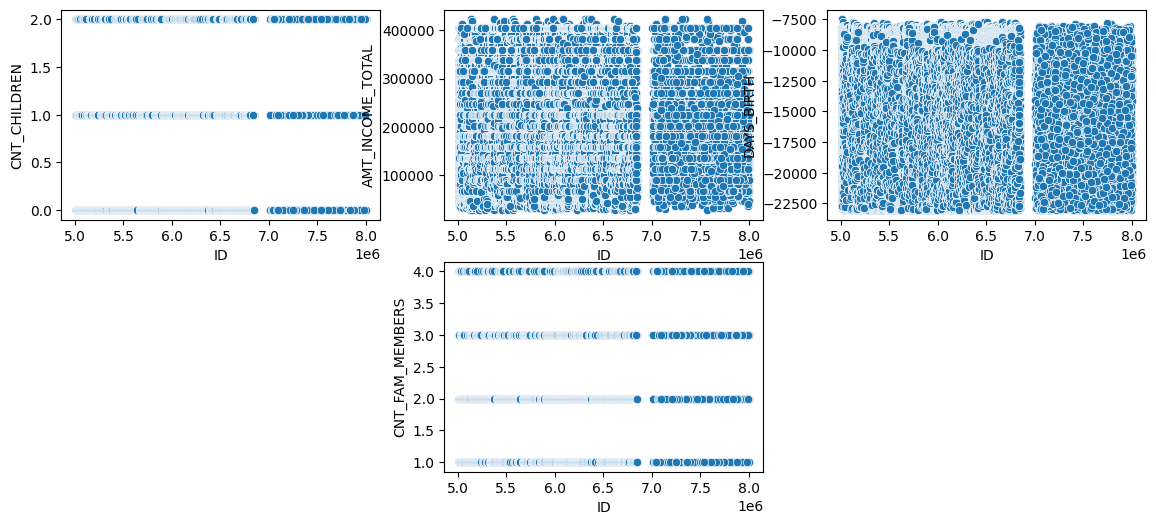

In [22]:
fig, ax= plt.subplots(nrows= 2, ncols = 3, figsize= (14,6))

sns.scatterplot(x='ID', y='CNT_CHILDREN', data=application, ax=ax[0][0])
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=application, ax=ax[0][1])
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=application, ax=ax[0][2])
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=application, ax=ax[1][1])
fig.delaxes(ax[1][2])
fig.delaxes(ax[1][0])

In [22]:
# Так как данных очень много, то самый просто способ закодировать категориальные - labelnecoding
label_enc = LabelEncoder()
cols_ob = [x for x in application.columns if application[x].dtype == 'object']
for name in cols_ob:
        application[name] = label_enc.fit_transform(application[name])

In [23]:
application.sample(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OCCUPATION_TYPE,CNT_FAM_MEMBERS
172454,5820775,1,0,1,2,135000.0,2,4,1,5,-12939,-4505,18,4.0
343537,6415191,1,0,1,1,126000.0,4,1,1,1,-8800,-567,18,3.0
433788,7344118,1,0,0,1,180000.0,4,4,0,1,-12556,-820,18,3.0
34376,5099820,0,0,1,0,72000.0,1,4,1,1,-21908,365243,18,2.0
135828,6564873,0,0,1,0,90000.0,2,4,1,1,-16754,-548,18,2.0
313198,6241548,1,0,1,0,112500.0,0,3,3,1,-13589,-1305,4,1.0
22741,5067173,0,0,0,0,122400.0,4,4,1,1,-20952,-1155,11,2.0
107671,5453970,1,1,0,0,180000.0,4,4,1,1,-20059,-1529,8,2.0
48442,5148923,0,1,1,0,157500.0,4,4,1,1,-16415,-9756,8,2.0
319554,6510133,1,0,1,1,225000.0,2,1,0,1,-13398,-5322,3,3.0


In [24]:
# Закодируем так же таргеты
credit['STATUS'] = label_enc.fit_transform(credit['STATUS'])
credit.sample(5)

,ID,MONTHS_BALANCE,STATUS
159055,5012270,-43,7
262483,5023662,-26,0
613782,5079046,0,7
399425,5046513,-2,6
470429,5058383,-14,7


In [25]:
# После очистки склеим оба наших датасета
scoring = application.merge(credit, on='ID', how='inner')
scoring.shape

(708642, 16)

In [33]:
scoring.isnull().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
MONTHS_BALANCE         0
STATUS                 0
dtype: int64

In [34]:
scoring.sample(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
134721,5033857,1,1,0,1,270000.0,0,1,1,2,-12928,-239,10,3.0,-12,0
128190,5033460,1,1,1,1,202500.0,4,4,1,1,-13876,-6990,8,3.0,-1,7
108002,5028598,0,1,1,2,225000.0,2,1,1,1,-11359,-1726,3,4.0,-38,0
500824,5105846,0,0,0,0,135000.0,1,4,4,1,-21349,365243,18,1.0,-1,6
153940,5036951,1,1,1,0,157500.0,4,4,1,1,-9430,-1346,8,2.0,-36,7
68872,5023250,0,0,1,0,67500.0,1,4,1,1,-19549,365243,18,2.0,-19,6
86869,5024488,1,0,1,0,171000.0,4,4,1,1,-21717,-2042,4,2.0,-17,6
512771,5112850,0,1,1,0,180000.0,4,4,1,1,-12172,-1681,10,2.0,-21,7
566600,5117397,0,1,0,0,292500.0,4,4,0,1,-15120,-735,18,2.0,-1,6
658630,5143220,0,0,1,0,67500.0,1,3,3,1,-22145,365243,18,1.0,-23,6


In [35]:
scoring['STATUS'].value_counts()

STATUS
6    300208
0    264448
7    133514
1      8020
5      1307
2       714
3       242
4       189
Name: count, dtype: int64

In [36]:
X = scoring.drop('STATUS', axis=1)
y = scoring['STATUS']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [56]:
balanced = SMOTE()
X_balanced, y_balanced = balanced.fit_resample(X_train, y_train)
# Прошу отметить, что я не применял SMOTE к test, чтобы проверить метрику на реальных данных

In [59]:
y_balanced.value_counts()

STATUS
6    240074
0    240074
7    240074
1    240074
5    240074
4    240074
3    240074
2    240074
Name: count, dtype: int64

In [76]:
# так как данных очень много, то сделаю случайную выборку с целью, чтобы новые данные были репрезентативны
# но при этом прежнего размера
# Чтобы точно не напутать, буду использовать простой train_test_split
X_small, X_, y_small, y_ = train_test_split(X_balanced, y_balanced, train_size=0.4)

In [77]:
y_small.value_counts()

STATUS
5    96331
2    96308
4    96180
6    96103
7    95895
0    95865
1    95852
3    95702
Name: count, dtype: int64

In [78]:
# После работы с данными можно приступать к машинному обучению
# В качестве метрики будем использовать ROC-AUC и смотреть на accuracy (не ключевая метрика в задаче,
# но интересно за ней понаблюдать)

In [79]:
# В качестве бэйзлайна возьму логистическую регрессию с параметрами по умолчанию
model = LogisticRegression(max_iter=1000)
model.fit(X_small, y_small)

LogisticRegression(max_iter=1000)

In [84]:
predict = model.predict(X_small)
acc(predict, y_small)

0.17776438490255597

In [85]:
acc(model.predict(X_test), y_test)

0.022775860974112567

In [ ]:
# Как видно модель плохо справляется 
# Попробую деревья

In [87]:
dtc = DecisionTreeClassifier()
dtc.fit(X_small, y_small)

DecisionTreeClassifier()

In [97]:
# скор уже выше. Отмечу, что тест на первоначальных, крайне несбалансированных данных
print('acc: ', acc(dtc.predict(X_test), y_test))
print('f1 : ', f1(dtc.predict(X_test), y_test, average = 'macro'))

acc:  0.8104551644335316
f1 :  0.4567411069328683


In [100]:
# Случайный лес
rfc = RandomForestClassifier()
rfc.fit(X_small, y_small)
print('acc: ', acc(rfc.predict(X_test), y_test))
print('f1 : ', f1(rfc.predict(X_test), y_test, average = 'macro'))

acc:  0.822167657995188
f1 :  0.46550374405201245


In [103]:
print('f1 на обработанных данных',f1(rfc.predict(X_), y_,average = 'macro'))

f1 на обработанных данных 0.8913559371415023


In [105]:
# Применим PCA, чтобы данные были компактнее и перейдем к более сложным моделям
pca = PCA(n_components=0.9)
pca.fit_transform(X_small)
X_pca = pca.transform(X_small)

In [109]:
# примени случайный лес снова
rfc = RandomForestClassifier()
rfc.fit(X_pca, y_small)

RandomForestClassifier()

In [110]:
acc(rfc.predict(X_pca), y_small)

0.8508036592921967

In [111]:
X_test_pca = pca.transform(X_test)

In [112]:
# Небольшая потеря при применеии Pca, но зато теперь 2 компоненты, а не 15
acc(rfc.predict(X_test_pca), y_test)

0.6985161822915564

In [116]:
# Применим градиентный бустинг к данным с pca
gbc = GradientBoostingClassifier()
gbc.fit(X_pca, y_small)

GradientBoostingClassifier()

In [118]:
acc(gbc.predict(X_pca), y_small)

0.384187931833447

In [129]:
# В завершении метод ближайших соседей
km = KNeighborsClassifier()
km.fit(X_pca, y_small)

KNeighborsClassifier()

In [130]:
print('acc: ', acc(km.predict(X_test_pca), y_test))
print('f1 : ', f1(km.predict(X_test_pca), y_test, average = 'macro'))

acc:  0.78200650537293
f1 :  0.42531779206269116


In [141]:
# вычислительно я себе могу позволить только grid searc cv только для knn так что опробуем))
grid_par = {'n_neighbors':[1,5,10,20]}
gsc = GridSearchCV(KNeighborsClassifier(), grid_par)


In [142]:
stand = StandardScaler()
stand.fit_transform(X_pca)
X_pca = stand.transform(X_pca)
gsc.fit(X_pca, y_small)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 5, 10, 20]})

In [143]:
gsc.best_params_

{'n_neighbors': 1}

In [149]:
print('acc train : ', acc(gsc.predict(X_pca), y_small))

acc train :  0.9544918488589443


In [154]:
print('acc test : ', acc(gsc.predict(stand.transform(X_test_pca)), y_test))

acc test :  0.3312448405054717


In [155]:
# Так как результат на трейне сильно лучше имеет смысл поработать со всеми доступными нам данными
pca = PCA(n_components = 0.9)
pca.fit_transform(X_balanced)
X_balanced = pca.transform(X_balanced)

In [159]:
stand.fit_transform(X_balanced)
X_balanced = stand.transform(X_balanced)

In [160]:
gsc.fit(X_balanced, y_balanced)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 5, 10, 20]})

In [173]:
print('acc train : ', acc(gsc.predict(X_balanced), y_balanced))
print('acc test : ', acc(gsc.predict(stand.transform(pca.transform(X_test))), y_test))
print('f1 train : ', f1(gsc.predict(stand.transform(pca.transform(X_test))), y_test, average='macro'))
print('f1 train : ', f1(gsc.predict(X_balanced), y_balanced, average='macro'))
print('prec test : ', precision_score(gsc.predict(stand.transform(pca.transform(X_test))), y_test, average='macro'))

acc train :  0.9109399601789449
acc test :  0.8693280838783877
f1 train :  0.47905930821525067
f1 train :  0.9110564724300009
prec test :  0.5183843310119534


In [ ]:
# Итак, как видим лучше всего с задачей справились KNN и  Random forest
# Не смотря на неплохое accuracy, f1 все же мало, что говорит о том, 
# что до конца не удалось побороть дислбалан классов

In [26]:
# Давайте теперь решим задачу кредитного скоринга
scoring.sample(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
47348,5021878,1,0,1,2,135000.0,4,4,1,1,-13534,-2557,8,4.0,-4,6
236760,5052723,0,0,1,1,180000.0,4,4,3,2,-10740,-1298,8,2.0,-11,0
567282,5117444,1,1,0,0,180000.0,4,4,1,1,-20037,-2349,4,2.0,-43,0
391401,5089463,0,0,0,2,67500.0,4,4,1,2,-13891,-248,3,4.0,-49,0
737,5008853,1,1,1,0,112500.0,0,4,1,1,-20502,-4450,4,2.0,-32,0


In [32]:
# Вернем метки на место
credit["STATUS"] = label_enc.inverse_transform(credit["STATUS"])

In [35]:
scoring = application.merge(credit, on='ID', how='inner')
scoring.shape

(708642, 16)

In [37]:
#Удалю данные где есть тип С - платил в месяце, так как нам это мало что говорит
# И X - не платил в месяце, так как банки не будут давать кредиты должникам
scoring = scoring[(scoring['STATUS'] != 'C') & (scoring['STATUS'] != 'X')]

In [38]:
scoring.shape

(274920, 16)

In [39]:
scoring.sample(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
611397,5132751,0,1,0,0,225000.0,0,1,1,5,-11828,-165,0,2.0,-5,0
140783,5035701,0,0,1,0,112500.0,2,3,1,1,-19814,-2656,8,2.0,-23,0
210888,5047658,0,1,0,1,162000.0,4,4,2,1,-14786,-4601,14,2.0,-1,0
143194,5036412,0,0,1,0,83250.0,1,4,0,1,-20219,365243,18,2.0,-2,0
8437,5009329,1,1,0,0,267750.0,4,1,1,1,-20991,-4727,8,2.0,-29,0


In [41]:
scoring["STATUS"].value_counts()

STATUS
0    264448
1      8020
5      1307
2       714
3       242
4       189
Name: count, dtype: int64

In [48]:
# Если задержка 60-90 дней пункт (2)
# То считаем, что клиент не вернет долг
scoring['STATUS'] = scoring['STATUS'].apply(lambda x: True if int(x) > 1  else False )

In [57]:
scoring['DEFAULT'] = scoring['STATUS']  
scoring.drop("STATUS", axis = 1, inplace = True)

In [58]:
scoring.sample(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,DEFAULT
214094,5047857,1,1,1,1,292500.0,0,1,1,1,-12569,-3322,18,3.0,-37,False
340703,5068025,1,1,1,1,157500.0,2,1,1,1,-11609,-2495,18,3.0,-37,False
627025,5137163,0,0,0,0,211500.0,4,4,1,1,-17249,-1661,18,2.0,-11,False
332697,5067528,0,0,1,0,90000.0,1,4,3,1,-22062,365243,18,1.0,-42,False
621060,5135910,0,0,1,0,135000.0,4,4,1,1,-11090,-321,14,2.0,-1,False


In [ ]:
# Итак, теперь новый таргет DEFAULT: True - дефолт, False - с клиентом все в порядке

In [60]:
# Данные снова разбалансированы, поэтому вначале разобьем на тест и трейн, а поток к трейну применим smote
scoring['DEFAULT'].value_counts()

DEFAULT
False    272468
True       2452
Name: count, dtype: int64

In [62]:
X = scoring.drop('DEFAULT', axis = 1)
y = scoring['DEFAULT']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

In [66]:
balanc = SMOTE()
X_balanced, y_balanced = balanc.fit_resample(X_train, y_train)

In [67]:
y_balanced.value_counts()

DEFAULT
False    217954
True     217954
Name: count, dtype: int64

In [127]:
# Посмотрим как решает регрессия данную задачу 
model = LogisticRegression()
model.fit(X_balanced, y_balanced)

LogisticRegression()

In [128]:
print('acc train : ', acc(model.predict(X_balanced), y_balanced))
print('acc test : ', acc(model.predict(X_test), y_test))
print('roc test', roc(model.predict(X_test),y_test))

acc train :  0.530820723638933
acc test :  0.524443474465299
roc test 0.5005980527249436


In [125]:
# посмотрим на на данных score без smote
model = LogisticRegression(class_weight = 'balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [126]:
print('acc train : ', acc(model.predict(X_train), y_train))
print('acc test : ', acc(model.predict(X_test), y_test))
print('roc test', roc(model.predict(X_test),y_test))

acc train :  0.5325685654008439
acc test :  0.5376291284737378
roc test 0.5003593511029226


In [108]:
# с балансировкой классов и без результаты одинаковы
param_grid = {'C' : np.logspace(1, 6, 12)}
gsc = GridSearchCV(LogisticRegression(class_weight = 'balanced', n_jobs = -1, penalty = 'l2'), param_grid, cv = 5)
param_grid

{'C': array([1.00000000e+01, 2.84803587e+01, 8.11130831e+01, 2.31012970e+02,
        6.57933225e+02, 1.87381742e+03, 5.33669923e+03, 1.51991108e+04,
        4.32876128e+04, 1.23284674e+05, 3.51119173e+05, 1.00000000e+06])}

In [109]:
gsc.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced', n_jobs=-1),
             param_grid={'C': array([1.00000000e+01, 2.84803587e+01, 8.11130831e+01, 2.31012970e+02,
       6.57933225e+02, 1.87381742e+03, 5.33669923e+03, 1.51991108e+04,
       4.32876128e+04, 1.23284674e+05, 3.51119173e+05, 1.00000000e+06])})

In [110]:
gsc.best_params_

{'C': 10.0}

In [124]:
print('acc train : ', acc(gsc.predict(X_train), y_train))
print('acc test : ', acc(gsc.predict(X_test), y_test))
print('roc test', roc(gsc.predict(X_test),y_test))

acc train :  0.5325685654008439
acc test :  0.5376291284737378
roc test 0.5003593511029226


In [115]:
bag = BaggingClassifier(estimator = LogisticRegression(class_weight='balanced', penalty='l2'))

In [116]:
bag.fit(X_train, y_train)

BaggingClassifier(estimator=LogisticRegression(class_weight='balanced'))

In [123]:
print('acc train : ', acc(bag.predict(X_train), y_train))
print('acc test : ', acc(bag.predict(X_test), y_test))
print('roc test', roc(bag.predict(X_test),y_test))

acc train :  0.522320129492216
acc test :  0.5240615451767787
roc test 0.5005914642942727


In [155]:
# Как видно bagging из коробки дает слабые результы, попробуем случайный лес
rfc = RandomForestClassifier(n_estimators=250,
                              min_samples_leaf=12,
                              )

In [119]:
rfc.fit(X_balanced, y_balanced)

RandomForestClassifier(min_samples_leaf=12, n_estimators=250)

In [129]:
print('acc train : ', acc(rfc.predict(X_train), y_train))
print('acc test : ', acc(rfc.predict(X_test), y_test))
print('roc test : ', roc(rfc.predict(X_test),y_test))

acc train :  0.9852411610650371
acc test :  0.9845227702604394
roc test :  0.6676650753937949


In [156]:
#  обучим на несбалансированных данных
rfc.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=12, n_estimators=250)

In [157]:
print('acc train : ', acc(rfc.predict(X_train), y_train))
print('acc test : ', acc(rfc.predict(X_test), y_test))
print('roc test : ', roc(rfc.predict(X_test),y_test))

acc train :  0.9936845264076822
acc test :  0.9933798923323148
roc test :  0.908529911639868


In [134]:
# как видно несбалансированные данные показывают просто прекрасные результат
# Выжмем максимальную метрику из деревьев
rfc = RandomForestClassifier(n_estimators=400,
                              min_samples_leaf=12
                              )
rfc.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=12, n_estimators=400)

In [135]:
print('acc train : ', acc(rfc.predict(X_train), y_train))
print('acc test : ', acc(rfc.predict(X_test), y_test))
print('roc test : ', roc(rfc.predict(X_test),y_test))

acc train :  0.9935435763131093
acc test :  0.9931798341335661
roc test :  0.8981367448903261


In [148]:
grid_param = {"max_depth" : np.arange(5,16,3), 'min_samples_leaf' : np.arange(2,17,5)}
grid_param

{'max_depth': array([ 5,  8, 11, 14]), 'min_samples_leaf': array([ 2,  7, 12])}

In [158]:
gsc = GridSearchCV(RandomForestClassifier(n_estimators=250), grid_param)

In [159]:
gsc.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=250),
             param_grid={'max_depth': array([ 5,  8, 11, 14]),
                         'min_samples_leaf': array([ 2,  7, 12])})

In [168]:
print('acc train : ', acc(gsc.predict(X_train), y_train))
print('acc test : ', acc(gsc.predict(X_test), y_test))
print('roc test : ', roc(gsc.predict(X_test),y_test))
print('recall False test : ', recall_score(gsc.predict(X_test),y_test, pos_label=False))
print('recall False True : ', recall_score(gsc.predict(X_test),y_test, pos_label=True))

acc train :  0.9955850792957951
acc test :  0.9951076676851448
roc test :  0.9690280380944597
recall False test :  0.9953247986558796
recall False True :  0.9427312775330396


In [169]:
gsc.best_params_

{'max_depth': 14, 'min_samples_leaf': 2}

In [ ]:
# Итак, на roc-auc метрика 0.96, что очень хороший результат
# Так же recall показал, что было выявлено 94!!! процента людей, которые не платили бы кредит
#  А тем, кто способен это сделать, ошибка лишь 0.5 процента